In [12]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [42]:
df = pd.read_csv( "data_W.csv" )
out_path = "./img3/"

In [43]:
# Funzione di ordinamento numerico robusta
def sort_by_num(labels):
    """Ordina etichette come S1..S10 o XS1..XS10 in base al numero finale."""
    return sorted(labels, key=lambda x: int(''.join([c for c in x if c.isdigit()])))

In [44]:
factor_cols = ['rmrf', 'smb', 'hml', 'umd']
xs_w_cols = [f'XS{i}_W' for i in range(1, 11)]

use_w = df[xs_w_cols + factor_cols].dropna().copy()

X = sm.add_constant(use_w[factor_cols])  # aggiunge l'intercetta

# --- run OLS for each XS ---
results_w = {}  # per riusare nei punti successivi
for xs_w in xs_w_cols:
    y = use_w[xs_w]
    model = sm.OLS(y, X)
    results_w[xs_w] = model.fit()

results_w = {k.replace('_W', ''): v for k, v in results_w.items()}

In [45]:
# estraiamo betas e alpha in un DataFrame indicizzato per portfolio (XS1..XS10)
rows = []
for k, res in results_w.items():
    params = res.params  # index: ['const','rmrf','smb','hml','umd']
    rows.append({
        "portfolio": k,                # XS1..XS10
        "alpha": float(params.get("const", np.nan)),
        "beta_M": float(params["rmrf"]),
        "beta_SMB": float(params["smb"]),
        "beta_HML": float(params["hml"]),
        "beta_UMD": float(params["umd"]),
        "r2": res.rsquared,
        "r2_adj": res.rsquared_adj,
    })

ts_summary = pd.DataFrame(rows).set_index("portfolio")
ts_summary = ts_summary.loc[sort_by_num(ts_summary.index)] 
print("Time-series betas/alpha/metrics")
display(ts_summary)

Time-series betas/alpha/metrics


,alpha,beta_M,beta_SMB,beta_HML,beta_UMD,r2,r2_adj
portfolio,,,,,,,
XS1,0.005379,0.669732,0.833417,0.104161,0.095220,0.602309,0.597866
XS2,0.005661,0.746535,0.895935,0.055465,-0.029742,0.719466,0.716332
XS3,0.003461,0.744901,0.922583,0.073947,0.004086,0.777465,0.774979
XS4,0.002398,0.808085,1.004553,-0.106107,0.086681,0.829780,0.827878
XS5,0.001190,0.864139,0.904032,0.040708,0.053836,0.849612,0.847931
XS6,0.001816,0.893728,0.882555,0.020540,0.014411,0.887605,0.886349
XS7,0.001018,0.924632,0.844916,-0.016041,0.008724,0.907338,0.906303
XS8,0.000472,0.995537,0.724549,-0.034221,0.045609,0.925851,0.925022
XS9,0.001302,1.067398,0.451884,-0.008440,-0.060537,0.921052,0.920170


In [46]:
s_cols = [f"S{i}" for i in range(1, 11)]     # returns "normali"
mean_returns = df[s_cols].mean().rename("mean_return")
mean_returns = mean_returns.loc[sort_by_num(mean_returns.index)]

print("Mean returns (ordinati S1..S10)")
mean_returns.to_frame().T

Mean returns (ordinati S1..S10)


,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10
mean_return,0.01665,0.016256,0.014449,0.013707,0.012983,0.013358,0.012494,0.012391,0.012505,0.010822


In [ ]:
betas = ts_summary[["beta_M","beta_SMB","beta_HML","beta_UMD"]].copy()
betas.index = [idx.replace("XS", "S") for idx in betas.index]
betas = betas.loc[sort_by_num(betas.index)] 

betas = betas.loc[mean_returns.index]

# Cross-section: mean returns ~ const + beta_M + beta_X
def run_cs_reg(y, Xdf, spec_name, add_const=True):
    X_ = sm.add_constant(Xdf) if add_const else Xdf.copy()
    res = sm.OLS(y.values, X_.values).fit()
    idx = (["const"] if add_const else []) + list(Xdf.columns)
    table = pd.DataFrame({"coef":res.params,"std_err(HC1)":res.bse,"t":res.tvalues,"p>|t|":res.pvalues}, index=idx)
    metrics = pd.Series({"spec":spec_name,"n_obs":len(y),"r2":res.rsquared,"r2_adj":res.rsquared_adj})
    fitted = pd.Series(res.fittedvalues, index=y.index, name=f"fitted_{spec_name}")
    resid = y - fitted
    return table, metrics, fitted, resid, res

tab1, met1, fit1, resid1, _ = run_cs_reg(mean_returns, betas[["beta_M","beta_SMB"]], "M+SMB", add_const=True)
tab2, met2, fit2, resid2, _ = run_cs_reg(mean_returns, betas[["beta_M","beta_HML"]], "M+HML", add_const=True)
tab3, met3, fit3, resid3, _ = run_cs_reg(mean_returns, betas[["beta_M","beta_UMD"]], "M+UMD", add_const=True)

display(tab1, met1.to_frame().T)
display(tab2, met2.to_frame().T)
display(tab3, met3.to_frame().T)

,coef,std_err(HC1),t,p>|t|
const,0.021324,0.003215,6.633093,0.000295
beta_M,-0.010190,0.003140,-3.245503,0.014145
beta_SMB,0.001438,0.001126,1.277167,0.242272


,spec,n_obs,r2,r2_adj
0,M+SMB,10,0.751985,0.681124


,coef,std_err(HC1),t,p>|t|
const,0.022664,0.003084,7.348303,0.000156
beta_M,-0.010605,0.003487,-3.041364,0.018811
beta_HML,0.005728,0.007135,0.802799,0.448486


,spec,n_obs,r2,r2_adj
0,M+HML,10,0.719974,0.639967


,coef,std_err(HC1),t,p>|t|
const,0.025950,0.002655,9.775273,0.000025
beta_M,-0.013995,0.002946,-4.750736,0.002082
beta_UMD,-0.010985,0.007472,-1.470209,0.184968


,spec,n_obs,r2,r2_adj
0,M+UMD,10,0.766343,0.699584


In [48]:
def pick(tab, name):
    # utile se l'indice è 'const', 'beta_M', 'beta_SMB', ...
    r = tab.loc[name]
    return pd.Series({"coef": r["coef"], "p": r["p>|t|"]})

summary_tbl = pd.DataFrame({
    "M+SMB: const":      pick(tab1, "const"),
    "M+SMB: beta_M":     pick(tab1, "beta_M"),
    "M+SMB: beta_SMB":   pick(tab1, "beta_SMB"),
    "M+HML: const":      pick(tab2, "const"),
    "M+HML: beta_M":     pick(tab2, "beta_M"),
    "M+HML: beta_HML":   pick(tab2, "beta_HML"),
    "M+UMD: const":      pick(tab3, "const"),
    "M+UMD: beta_M":     pick(tab3, "beta_M"),
    "M+UMD: beta_UMD":   pick(tab3, "beta_UMD"),
}).T

r2_tbl = pd.DataFrame({
    "spec": [met1["spec"], met2["spec"], met3["spec"]],
    "R²":   [met1["r2"],   met2["r2"],   met3["r2"]],
    "R²_adj": [met1["r2_adj"], met2["r2_adj"], met3["r2_adj"]],
})

display(summary_tbl)
display(r2_tbl)

,coef,p
M+SMB: const,0.021324,0.000295
M+SMB: beta_M,-0.010190,0.014145
M+SMB: beta_SMB,0.001438,0.242272
M+HML: const,0.022664,0.000156
M+HML: beta_M,-0.010605,0.018811
M+HML: beta_HML,0.005728,0.448486
M+UMD: const,0.025950,0.000025
M+UMD: beta_M,-0.013995,0.002082
M+UMD: beta_UMD,-0.010985,0.184968


,spec,R²,R²_adj
0,M+SMB,0.751985,0.681124
1,M+HML,0.719974,0.639967
2,M+UMD,0.766343,0.699584


KeyError: 'SMB'

<Figure size 640x480 with 0 Axes>

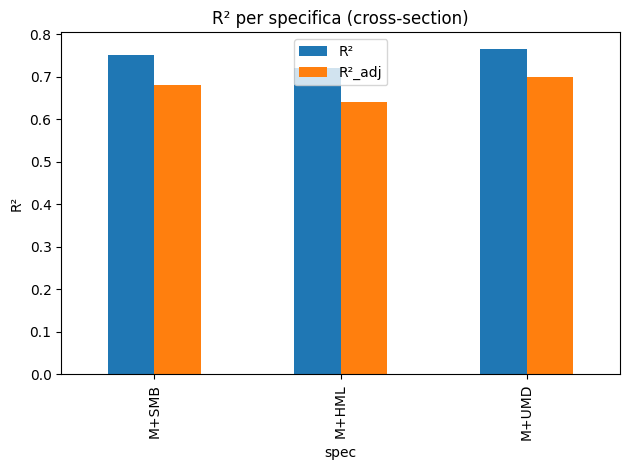

In [49]:
# R^2 per specifica
plt.figure()
r2_tbl.set_index("spec")[["R²", "R²_adj"]].plot(kind="bar")
plt.title("R² per specifica (cross-section)")
plt.ylabel("R²")
plt.tight_layout()

# Scatter "parziali": mean return vs beta_M (controllando per l'altro)
# Costruiamo i fitted separando l’effetto del fattore extra
def partial_scatter(y, betas, spec, other):
    # Regressione y ~ const + beta_M + other già fatta
    # Calcolo componente parziale: y - gamma_other * other
    if spec == "M+SMB":
        g_other = tab1.loc[other, "coef"]
        x_other = betas[other.replace("beta_", "")]
        resid_y = y - g_other * x_other
        x = betas["beta_M"]
        title = "Mean return (depurato SMB) vs beta_M"
    elif spec == "M+HML":
        g_other = tab2.loc[other, "coef"]
        x_other = betas[other.replace("beta_", "")]
        resid_y = y - g_other * x_other
        x = betas["beta_M"]
        title = "Mean return (depurato HML) vs beta_M"
    else:
        g_other = tab3.loc[other, "coef"]
        x_other = betas[other.replace("beta_", "")]
        resid_y = y - g_other * x_other
        x = betas["beta_M"]
        title = "Mean return (depurato UMD) vs beta_M"

    plt.figure()
    plt.scatter(x, resid_y)
    for i, lbl in enumerate(y.index):
        plt.annotate(lbl, (x.iloc[i], resid_y.iloc[i]), xytext=(5,5), textcoords="offset points")
    plt.xlabel("beta_M")
    plt.ylabel("Mean return (parziale)")
    plt.title(title)
    plt.tight_layout()

partial_scatter(mean_returns, betas, "M+SMB", "beta_SMB")
partial_scatter(mean_returns, betas, "M+HML", "beta_HML")
partial_scatter(mean_returns, betas, "M+UMD", "beta_UMD")